<a href="https://colab.research.google.com/github/pasdptt/PasdPublicNB/blob/master/PCAinAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCA in Action

With techniques from linear algebra
This blog post by Sebastian Raschka provides a clean and useful overview of our approach to PCA. This is what we will implement in the following lines to reduce our data to  k  dimensions:

1. Standardize the data. (To make quantitative comparisons of variance, we want to be sure each measurement varies to a similar extent; more on this later.)
2. Compute the covariance matrix and use eigenvalue decomposition to obtain the eigenvectors and eigenvalues.
3. Select the  k  largest eigenvalues and their associated eigenvectors.
4. Transform the data into a  k  dimensional subspace using those  k  eigenvectors.

Let's give it a try!

#PCA step-by-step

##Required libs

In [1]:
import numpy as np
import numba
import pandas as pd
import scipy.special
import scipy.stats as st
import sklearn

# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

# BE/Bi 103 Utilities from Justin
# import bebi103

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

import bokeh

##Load Iris Dataset

**The famous iris data set**

We will use one of the most famous datasets available online. This data set, collected by Edgar Anderson and popularized by the one and only Ronald Fisher, contains the petal and sepal length and width in three different species of Iris (Iris setosa, Iris virginica and Iris versicolor).

This data set is popular enough to have its own Wikipedia entry, and you can import it with seaborn, scikit-learn, or even pandas using

```
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(filepath_or_buffer=url, header=None, sep=',')
```

For this tutorial, we will import it using scikit-learn and transform it into a tidy data frame.

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

In [3]:
# loading dataset into Pandas DataFrame
df = pd.read_csv(url
                 , names=['sepal length','sepal width','petal length','petal width','target'])

In [4]:
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df.count()

sepal length    150
sepal width     150
petal length    150
petal width     150
target          150
dtype: int64

We can plot pairwise comparisons using Seaborn's pairplot() function to see if there are striking correlations between any two features of the iris data set. If any two features are highly correlated, we may assume we can summarize those two features with a single axis (i.e. "new" feature) that includes both.

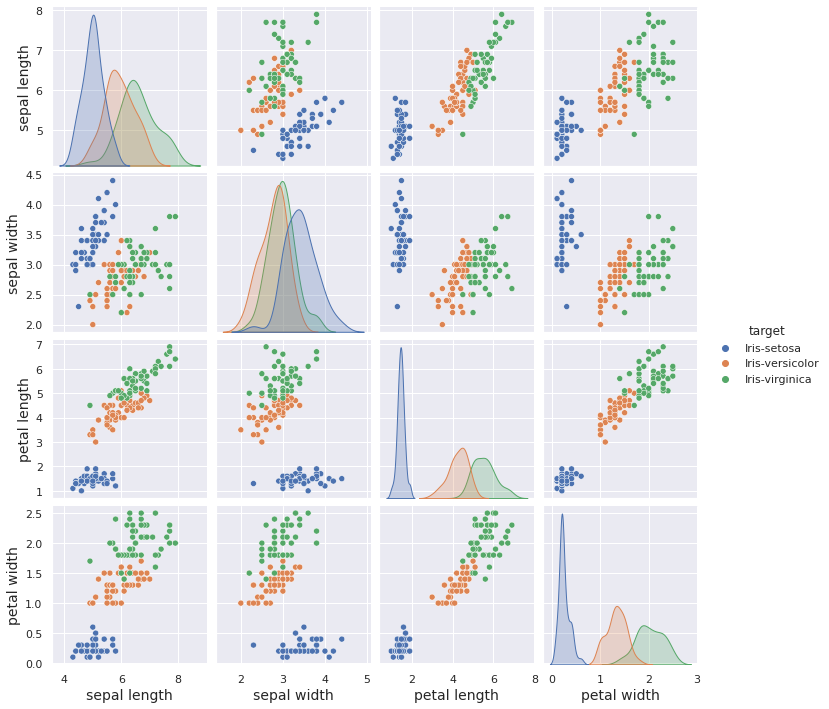

In [6]:
# Plot pairwise comparison to explore the data
_ = sns.pairplot(df, hue='target')

Right away from this plot we can notice that versicolor and virginica are more similar to each other than to setosa. There is also a strong correlation between petal length and petal width. We can use this to explain the concept behind PCA. So, let's focus on these two parameters.

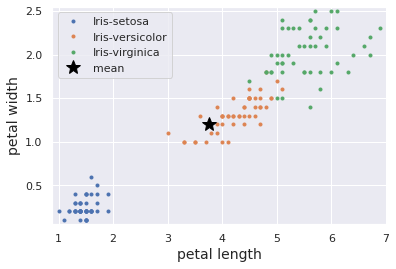

In [7]:
m = np.array([df['petal length'].mean(), 
              df['petal width'].mean()])

# Plot petal length vs petal width only
for key, group in df.groupby(['target']):
    plt.plot(group['petal length'], group['petal width'],
               label=key, marker='.', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15,
         linestyle='none', label='mean')

plt.legend(loc=0)
plt.margins(0.02)
plt.xlabel('petal length')
plt.ylabel('petal width');

##Trying to do PCA manaully

Now, we do "manual" PCA (or "Manuel" PCA, as he coded this approach first). Our goal will be to reduce our 2-D data to 1-D. Note that by taking the mean, we already reduced it 0-D in a sense.

**1) Standardize the data.** Because our plot labels have units, we know the two dimensions we're considering are both measured in centimeters, and so have similar scale. But they're different distances from zero! We'll center all measurements at the same point, the mean.

In [8]:
# Substract the mean from the measurements.
df_centered = df.loc[:, ['petal length', 'petal width']]
for col in df_centered.columns:
    df_centered[col] -= df_centered[col].mean()

# Take a look
df_centered.head()

,petal length,petal width
0,-2.358667,-0.998667
1,-2.358667,-0.998667
2,-2.458667,-0.998667
3,-2.258667,-0.998667
4,-2.358667,-0.998667


**2) Compute the covariance matrix and use eigenvalue decomposition to obtain the eigenvectors and eigenvalues.**

We won't cover the math behind this procedure. However, it can be shown that the principal component directions are given by the eigenvectors of the matrix, and the magnitudes of the components are given by the eigenvalues.

Most of the available algorithms to do PCA use singular value decomposition instead for computational efficiency. But regardless of the algorithm the objective is still the same: compute the eigenvectors and eigenvalues from the covariance matrix.

In [9]:
cov_mat = np.cov(df_centered.transpose())
print('Covariance matrix \n', cov_mat)

Covariance matrix 
 [[3.11317942 1.29638747]
 [1.29638747 0.58241432]]


In [10]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Eigenvectors
 [[ 0.92154695 -0.38826694]
 [ 0.38826694  0.92154695]]

Eigenvalues
 [3.65937449 0.03621925]


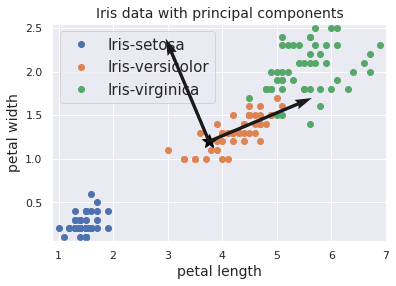

In [11]:
# Plot Petal length vs petal width only
for key, group in df.groupby(['target']):
    plt.plot(group['petal length'], group['petal width'],
               label=key, marker='o', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11, 
           width=0.01, scale=3)
    
# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.02)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.title('Iris data with principal components');

3) Select the  k  largest eigenvalues and their associated eigenvectors.

As Sebastian Raschka points out in his explanation of PCA:

The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

We chose this pair of measurements originally because there was a clear correlation between them. This is indeed confirmed by the relative magnitudes of the eigenvalues where one of them is two orders of magnitude larger than the other. Clearly, describing this data with two axes, rather than one, does not add much additional information. Also, we know which eigenvector to take: the one with the largest eigenvalue.

Lior Pachter's great blog post on PCA, which we will discuss more later, explains this 2-D to 1-D case by thinking of the projection as a triangle. Let's say we want to project a single data point onto the first principal component. The centroid (fixed) and the data point (also fixed) form a triangle with the the transformed data point (an orthogonal projection onto the first principal component).

The hypotenuse of the triangle (the distance from the centroid to the data point) is fixed, so the other two sides must change together (by the Pythagorean Theorem). The first principal component has a minimal orthogonal distance to all the data points. So the side of the triangle between the data point and the transformed data point is as small as possible. This means the distance between the centroid and the transformed point is as large as possible (though still smaller than the original distance between the data point and the centroid)!

This is what we mean when we say that using PCA to project the data into fewer dimensions maximizes the sample variation (i.e. their distances from each other after they've been transformed), despite some information being lost.

Luckily, we can quantify about how much information is lost. As the eigenvalues are a relative measure of the data variance along the associated eigenvector (i.e. the "new feature axis"), we can use them to quantify how much of the variance is explained by our  k  dimensions, which could be a useful way to decide what  k  should even be in the first place. In this case, we want to know how much of the 2-D spread is described by our 1-D simplification.**bold text**

In [12]:
# Compute how much variance is explained by each principal component
print("""
PCA 1: {0:.2f}% of the variance
PCA 2:  {1:.2f}% of the variance
""".format(*tuple(eig_vals / np.sum(eig_vals) * 100)))


PCA 1: 99.02% of the variance
PCA 2:  0.98% of the variance



**4) Transform the data into a  k  dimensional subspace using those  k  eigenvectors.**

To actually project our data into this new dimension, we have to multiply our data by the so-called projection matrix, which is the fancy name for concatenating the top  k  eigenvectors together. Then, the dot product of the data with the projection matrix "projects" the data onto our new axis.

Since in this simple example we are projecting into a 1D space, we just have to matrix multiply our data by the eigenvector with the largest corresponding eigenvalue.

In [13]:
# Project data to our 1D space
df_1D = pd.DataFrame(np.dot(df.loc[:,['petal length',
                                           'petal width']], eig_vecs[:,0]),
                     columns=['projection'])

# Add back the species column
df_1D['target'] = df['target']
df_1D.head()

,projection,target
0,1.367819,Iris-setosa
1,1.367819,Iris-setosa
2,1.275664,Iris-setosa
3,1.459974,Iris-setosa
4,1.367819,Iris-setosa


Now we can plot our data in 1D only while maintaining ≈98% percent of the variability in the data!

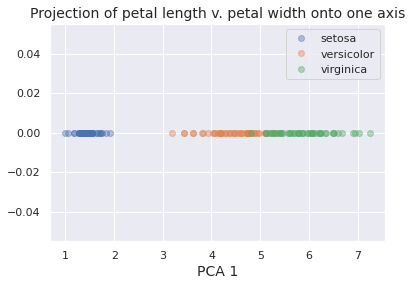

In [ ]:
for key, group in df_1D.groupby(['target']):
    plt.plot(group['projection'], np.zeros_like(group['projection']), alpha=0.4, 
             label=key, marker='o', linestyle='none')

plt.margins(0.05)
plt.xlabel('PCA 1')
plt.legend(np.array(['setosa', 'versicolor','virginica']))
plt.title('Projection of petal length v. petal width onto one axis');

##PCA using Scikitlearn

###Standardize the Data

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
x = df.loc[:, features].values

In [16]:
y = df.loc[:,['target']].values

In [17]:
x = StandardScaler().fit_transform(x)

In [18]:
pd.DataFrame(data = x, columns = features).head()

,sepal length,sepal width,petal length,petal width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


###PCA Projection to 2D

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=2)

In [21]:
principalComponents = pca.fit_transform(x)

In [22]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [23]:
principalDf.head(5)

,principal component 1,principal component 2
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767


In [24]:
df[['target']].head()

,target
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa


In [25]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,target
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa


###Visualize 2D Projection

Use a PCA projection to 2d to visualize the entire data set. You should plot different classes using different colors or shapes. Do the classes seem well-separated from each other?

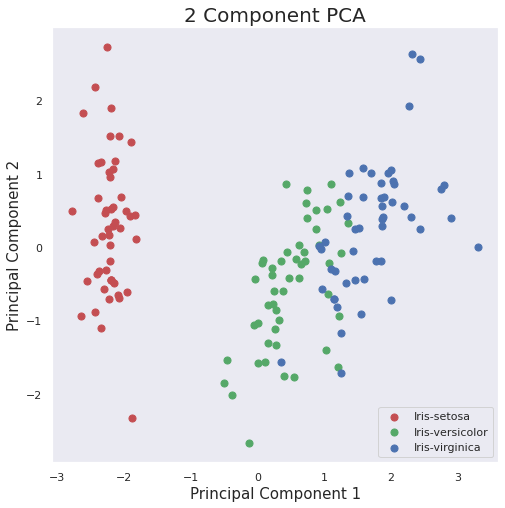

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

The three classes appear to be well separated!

iris-virginica and iris-versicolor could be better separated, but still good!

###Explained Variance

The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [ ]:
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

Together, the first two principal components contain 95.80% of the information. The first principal component contains 72.77% of the variance and the second principal component contains 23.03% of the variance. The third and fourth principal component contained the rest of the variance of the dataset.



#What are other applications of PCA (other than visualizing data)?

If your learning algorithm is too slow because the input dimension is too high, then using PCA to speed it up is a reasonable choice. (most common application in my opinion). We will see this in the MNIST dataset.

If memory or disk space is limited, PCA allows you to save space in exchange for losing a little of the data's information. This can be a reasonable tradeoff.

##PCA + Logistic Regression (MNIST)

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

<table>
<tr>
<th>Parameters</th>
<th>Number</th>
</tr>
<tr>
<th>Classes</th>
<th>10</th>
</tr>
<tr>
<th>Samples per class</th>
<th>~7000 samples per class</th>
</tr>
<tr>
<th>Samples total</th>
<th>70000</th>
</tr>
<tr>
<th>Dimensionality</th>
<th>784</th>
</tr>
<tr>
<th>Features</th>
<th>integers values from 0 to 255</th>
</tr>
</table>	

	
The MNIST database of handwritten digits is available on the following website: [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)

In [27]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

In [28]:
# You can add the parameter data_home to wherever to where you want to download your data
mnist = fetch_openml('mnist_784')

In [29]:
mnist

{'DESCR': "**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered i

In [30]:
# These are the images
mnist.data.shape

(70000, 784)

In [31]:
# These are the labels
mnist.target.shape

(70000,)

##Splitting Data into Training and Test Sets

In [32]:
# test_size: what proportion of original data is used for test set
train_img, test_img, train_lbl, test_lbl = train_test_split(
    mnist.data, mnist.target, test_size=1/7.0, random_state=0)

In [33]:
print(train_img.shape)

(60000, 784)


In [34]:
print(train_lbl.shape)

(60000,)


In [35]:
print(test_img.shape)

(10000, 784)


In [36]:
print(test_lbl.shape)

(10000,)


##Standardizing the Data

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data

Notebook going over the importance of feature Scaling: 

http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_img)

# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

##PCA to Speed up Machine Learning Algorithms (Logistic Regression)

###Step 0: Import and use PCA. After PCA you will apply a machine learning algorithm of your choice to the transformed data

In [38]:
from sklearn.decomposition import PCA

Make an instance of the Model

In [39]:
pca = PCA(.95)

Fit PCA on training set. Note: you are fitting PCA on the training set only



In [40]:
pca.fit(train_img)

PCA(n_components=0.95)

In [41]:
pca.n_components_

327

Apply the mapping (transform) to both the training set and the test set.

In [42]:
train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

###Step 1: Import the model you want to use

In sklearn, all machine learning models are implemented as Python classes

In [43]:
from sklearn.linear_model import LogisticRegression

###Step 2: Make an instance of the Model

In [44]:
# all parameters not specified are set to their defaults
# default solver is incredibly slow thats why we change it
# solver = 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs')

###Step 3: Training the model on the data, storing the information learned from the data

Model is learning the relationship between x (digits) and y (labels)

In [45]:
logisticRegr.fit(train_img, train_lbl)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

###Step 4: Predict the labels of new data (new images)

Uses the information the model learned during the model training process

In [46]:
# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(test_img[0].reshape(1,-1))

array(['0'], dtype=object)

In [47]:
# Predict for Multiple Observations (images) at Once
logisticRegr.predict(test_img[0:10])

array(['0', '4', '1', '2', '4', '7', '7', '1', '1', '7'], dtype=object)

###Step 5: Measuring Model Performance
accuracy (fraction of correct predictions): correct predictions / total number of data points

Basically, how the model performs on new data (test set)

In [48]:
score = logisticRegr.score(test_img, test_lbl)
print(score)

0.9201


In [ ]:
pd.DataFrame(data = [[1.00, 784, 48.94, .9158],
                     [.99, 541, 34.69, .9169],
                     [.95, 330, 13.89, .92],
                     [.90, 236, 10.56, .9168],
                     [.85, 184, 8.85, .9156]], 
             columns = ['Variance Retained',
                      'Number of Components', 
                      'Time (seconds)',
                      'Accuracy'])

,Variance Retained,Number of Components,Time (seconds),Accuracy
0,1.00,784,48.94,0.9158
1,0.99,541,34.69,0.9169
2,0.95,330,13.89,0.9200
3,0.90,236,10.56,0.9168
4,0.85,184,8.85,0.9156


#What are the limitations of PCA?

* PCA is not scale invariant. check: we need to scale our data first.
* The directions with largest variance are assumed to be of the most interest
* Only considers orthogonal transformations (rotations) of the original variables
* PCA is only based on the mean vector and covariance matrix. Some distributions (multivariate normal) are characterized by this, but some are not.
* If the variables are correlated, PCA can achieve dimension reduction. If not, PCA just orders them according to their variances.

#References and suggested video

References:

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html

http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2016/tutorials/aux4_pca.html

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_to_Speed-up_Machine_Learning_Algorithms.ipynb

Futher reading:

https://www.youtube.com/watch?v=FgakZw6K1QQ&ab_channel=StatQuestwithJoshStarmer

https://www.youtube.com/watch?v=rng04VJxUt4&ab_channel=ArtificialIntelligence-AllinOne